In [93]:
#importing the libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import string
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.manifold import TSNE

from nltk.tokenize import word_tokenize
from nltk.tokenize import sent_tokenize
from nltk.stem import WordNetLemmatizer 

from imblearn.over_sampling import SMOTE

In [94]:
#Function to get unique words and sentences from the entire dataset
def get_sentence_word_count(text_list):
    sent_count = 0
    word_count = 0
    vocab = {}
    for text in text_list:
        sentences=sent_tokenize(str(text).lower())
        sent_count = sent_count + len(sentences)
        for sentence in sentences:
            words=word_tokenize(sentence)
            for word in words:
                if(word in vocab.keys()):
                    vocab[word] = vocab[word] +1
                else:
                    vocab[word] =1 
    word_count = len(vocab.keys())
    return sent_count,word_count

In [95]:
#read csv fie
med_data=pd.read_csv("mtsamples.csv")
print(med_data.shape)


(4999, 6)


In [96]:
med_data.head()

,Unnamed: 0,description,medical_specialty,sample_name,transcription,keywords
0,0,A 23-year-old white female presents with comp...,Allergy / Immunology,Allergic Rhinitis,"SUBJECTIVE:, This 23-year-old white female pr...","allergy / immunology, allergic rhinitis, aller..."
1,1,Consult for laparoscopic gastric bypass.,Bariatrics,Laparoscopic Gastric Bypass Consult - 2,"PAST MEDICAL HISTORY:, He has difficulty climb...","bariatrics, laparoscopic gastric bypass, weigh..."
2,2,Consult for laparoscopic gastric bypass.,Bariatrics,Laparoscopic Gastric Bypass Consult - 1,"HISTORY OF PRESENT ILLNESS: , I have seen ABC ...","bariatrics, laparoscopic gastric bypass, heart..."
3,3,2-D M-Mode. Doppler.,Cardiovascular / Pulmonary,2-D Echocardiogram - 1,"2-D M-MODE: , ,1. Left atrial enlargement wit...","cardiovascular / pulmonary, 2-d m-mode, dopple..."
4,4,2-D Echocardiogram,Cardiovascular / Pulmonary,2-D Echocardiogram - 2,1. The left ventricular cavity size and wall ...,"cardiovascular / pulmonary, 2-d, doppler, echo..."


In [97]:
#number of sentences and unique words in transcription column
med_data = med_data[med_data['transcription'].notna()]
sent_count,word_count= get_sentence_word_count(med_data['transcription'].tolist())
print("Number of sentences in transcriptions column: "+ str(sent_count))
print("Number of unique words in transcriptions column: "+str(word_count))

Number of sentences in transcriptions column: 140214
Number of unique words in transcriptions column: 35822


In [98]:
#number data categories or classes
data_categories  = med_data.groupby(med_data['medical_specialty'])
i=1
for catName,dataCategory in data_categories:
    print('Cat:'+str(i)+' '+catName + ' : '+ str(len(dataCategory)) )
    i = i+1

Cat:1  Allergy / Immunology : 7
Cat:2  Autopsy : 8
Cat:3  Bariatrics : 18
Cat:4  Cardiovascular / Pulmonary : 371
Cat:5  Chiropractic : 14
Cat:6  Consult - History and Phy. : 516
Cat:7  Cosmetic / Plastic Surgery : 27
Cat:8  Dentistry : 27
Cat:9  Dermatology : 29
Cat:10  Diets and Nutritions : 10
Cat:11  Discharge Summary : 108
Cat:12  ENT - Otolaryngology : 96
Cat:13  Emergency Room Reports : 75
Cat:14  Endocrinology : 19
Cat:15  Gastroenterology : 224
Cat:16  General Medicine : 259
Cat:17  Hematology - Oncology : 90
Cat:18  Hospice - Palliative Care : 6
Cat:19  IME-QME-Work Comp etc. : 16
Cat:20  Lab Medicine - Pathology : 8
Cat:21  Letters : 23
Cat:22  Nephrology : 81
Cat:23  Neurology : 223
Cat:24  Neurosurgery : 94
Cat:25  Obstetrics / Gynecology : 155
Cat:26  Office Notes : 50
Cat:27  Ophthalmology : 83
Cat:28  Orthopedic : 355
Cat:29  Pain Management : 61
Cat:30  Pediatrics - Neonatal : 70
Cat:31  Physical Medicine - Rehab : 21
Cat:32  Podiatry : 47
Cat:33  Psychiatry / Psycholo

In [99]:
#Removing the categories which have less than 50 samples
filtered_data_categories = data_categories.filter(lambda x:x.shape[0] > 50)
final_data_categories = filtered_data_categories.groupby(filtered_data_categories['medical_specialty'])
i=1
print('============Filtered Categories ======================')
for catName,dataCategory in final_data_categories:
    print('Cat:'+str(i)+' '+catName + ' : '+ str(len(dataCategory)) )
    i = i+1


============Filtered Categories ======================
Cat:1  Cardiovascular / Pulmonary : 371
Cat:2  Consult - History and Phy. : 516
Cat:3  Discharge Summary : 108
Cat:4  ENT - Otolaryngology : 96
Cat:5  Emergency Room Reports : 75
Cat:6  Gastroenterology : 224
Cat:7  General Medicine : 259
Cat:8  Hematology - Oncology : 90
Cat:9  Nephrology : 81
Cat:10  Neurology : 223
Cat:11  Neurosurgery : 94
Cat:12  Obstetrics / Gynecology : 155
Cat:13  Ophthalmology : 83
Cat:14  Orthopedic : 355
Cat:15  Pain Management : 61
Cat:16  Pediatrics - Neonatal : 70
Cat:17  Psychiatry / Psychology : 53
Cat:18  Radiology : 273
Cat:19  SOAP / Chart / Progress Notes : 166
Cat:20  Surgery : 1088
Cat:21  Urology : 156


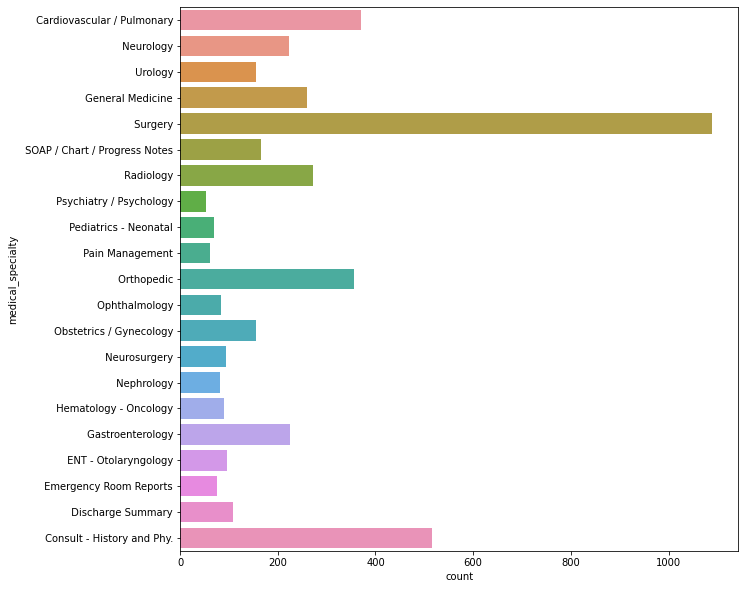

In [100]:
plt.figure(figsize=(10,10))
sns.countplot(y='medical_specialty', data = filtered_data_categories )
plt.show()

In [101]:
#We are interested only in the 'transcription' and 'medical_specialty' columns in the dataset as we are classifying the
#transciptions based on the medical category

In [102]:
data = filtered_data_categories[['transcription', 'medical_specialty']]
data = data.drop(data[data['transcription'].isna()].index)
data.shape

(4597, 2)

In [103]:
print('Before Data Cleaning :Sample Transcription 1:'+data.iloc[5]['transcription']+'\n')
print('After Data Cleaning :Sample Transcription 2:'+data.iloc[125]['transcription']+'\n')

Before Data Cleaning :Sample Transcription 1:CC:, Confusion and slurred speech.,HX , (primarily obtained from boyfriend): This 31 y/o RHF experienced a "flu-like illness 6-8 weeks prior to presentation. 3-4 weeks prior to presentation, she was found "passed out" in bed, and when awoken appeared confused, and lethargic. She apparently recovered within 24 hours. For two weeks prior to presentation she demonstrated emotional lability, uncharacteristic of her ( outbursts of anger and inappropriate laughter). She left a stove on.,She began slurring her speech 2 days prior to admission. On the day of presentation she developed right facial weakness and began stumbling to the right. She denied any associated headache, nausea, vomiting, fever, chills, neck stiffness or visual change. There was no history of illicit drug/ETOH use or head trauma.,PMH:, Migraine Headache.,FHX: , Unremarkable.,SHX: ,Divorced. Lives with boyfriend. 3 children alive and well. Denied tobacco/illicit drug use. Rarely 

In [104]:
#Defining Data cleaning methods
#1. Remove Punction mark
def clean_text(text ): 
    text = text.translate(str.maketrans('', '', string.punctuation))
    text1 = ''.join([w for w in text if not w.isdigit()]) 
    REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
    #BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
    
    text2 = text1.lower()
    text2 = REPLACE_BY_SPACE_RE.sub('', text2) # replace REPLACE_BY_SPACE_RE symbols by space in text
    #text2 = BAD_SYMBOLS_RE.sub('', text2)
    return text2

#2. Lemmatizing the text data
def lemmatize_text(text):
    wordlist=[]
    lemmatizer = WordNetLemmatizer() 
    sentences=sent_tokenize(text)
    
    intial_sentences= sentences[0:1]
    final_sentences = sentences[len(sentences)-2: len(sentences)-1]
    
    for sentence in intial_sentences:
        words=word_tokenize(sentence)
        for word in words:
            wordlist.append(lemmatizer.lemmatize(word))
    for sentence in final_sentences:
        words=word_tokenize(sentence)
        for word in words:
            wordlist.append(lemmatizer.lemmatize(word))       
    return ' '.join(wordlist) 

In [105]:
#Data Cleaning
data['transcription'] = data['transcription'].apply(lemmatize_text)
data['transcription'] = data['transcription'].apply(clean_text)

In [106]:
print('After Data Cleaning :Sample Transcription 1:'+data.iloc[5]['transcription']+'\n')
print('After Data Cleaning :Sample Transcription 2:'+data.iloc[125]['transcription']+'\n')

After Data Cleaning :Sample Transcription 1:cc   confusion and slurred speech  hx   primarily obtained from boyfriend   this  yo rhf experienced a  flulike illness  week prior to presentation  obgyn exam including cervical biopsy  and abdominalpelvic ct scanning revealed stage iv squamous cell cancer of the cervix 

After Data Cleaning :Sample Transcription 2:admitting diagnoses    this is scheduled for the week after discharge potentially by dr g  and the patient will discus the exact time later this week 



Peforming feature extraction using TfidfVectorizer to generate tf-idf features.
TFIDF, short for term frequency–inverse document frequency, is a numerical statistic that is intended to 
reflect how important a word is to a document in a collection or corpus.
It is often used as a weighting factor in searches of information retrieval, text mining, and user modeling.
The tf–idf value increases proportionally to the number of times a word appears in the document and is offset by the number of documents in the corpus that contain the word, which helps to adjust for the fact that some words appear more frequently in general.

In [107]:
vectorizer = TfidfVectorizer(analyzer='word', stop_words='english',ngram_range=(1,3), max_df=0.75, use_idf=True, smooth_idf=True, max_features=1000)
tfIdfMat  = vectorizer.fit_transform(data['transcription'].tolist() )

feature_names = sorted(vectorizer.get_feature_names())
print(feature_names)

['abc', 'abcd', 'abdomen', 'abdomen pelvis', 'abdominal', 'abdominal pain', 'abnormal', 'abscess', 'activity', 'acute', 'additional', 'adenocarcinoma', 'adequate', 'administered', 'admission', 'admitted', 'admitting', 'africanamerican', 'age', 'ago', 'airway', 'alcohol', 'anemia', 'anesthesia', 'anesthesia care', 'anesthesia general', 'anesthesia general endotracheal', 'anesthesia local', 'anesthesia wa', 'anesthetic', 'angina', 'angiography', 'ankle', 'anterior', 'antibiotic', 'aortic', 'apnea', 'apparent', 'appendicitis', 'applied', 'appointment', 'appropriate', 'approximately', 'area', 'arm', 'artery', 'artery disease', 'arthritis', 'arthroplasty', 'asked', 'aspect', 'aspiration', 'assessment', 'associated', 'atrial', 'atrial fibrillation', 'awakened', 'axial', 'axial ct', 'axial ct image', 'axis', 'baby', 'base', 'benefit', 'benign', 'better', 'bid', 'bilateral', 'bilaterally', 'biopsy', 'bladder', 'bleeding', 'block', 'blood', 'blood loss', 'blood loss cc', 'blood loss minimal', '

visualize the tf-idf features using t-sne plot.
t-sne stands for T-distributed Stochastic Neighbor Embedding is a machine learning algorithm for data visualization
It is a nonlinear dimensionality reduction technique well-suited for embedding high-dimensional data for visualization in a low-dimensional space of two or three dimensions. 
Specifically, it models each high-dimensional object by a two- or three-dimensional point in such a way that similar objects are modeled by nearby points and dissimilar objects are modeled by distant points with high probability.
The t-sne plot shows that lot of categories are overlapping with each other.

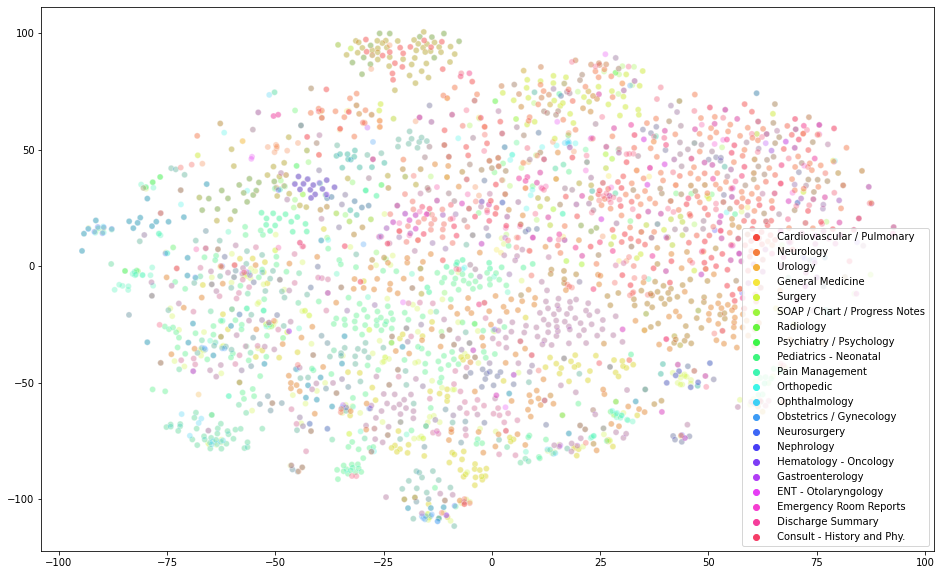

In [108]:
import gc
gc.collect()
tfIdfMatrix = tfIdfMat.todense()
labels = data['medical_specialty'].tolist()
tsne_results = TSNE(n_components=2,init='random',random_state=0, perplexity=40).fit_transform(tfIdfMatrix)
plt.figure(figsize=(16,10))
palette = sns.hls_palette(21, l=.6, s=.9)
sns.scatterplot(
    x=tsne_results[:,0], y=tsne_results[:,1],
    hue=labels,
    palette= palette,
    legend="full",
    alpha=0.3
)
plt.show()

Performing PCA to reduce dimensionality of features.
PCA is defined as an orthogonal linear transformation that transforms the data to a new coordinate system such that the greatest variance by some scalar projection of the data comes to lie on the first coordinate (called the first principal component), the second greatest variance on the second coordinate, and so on

In [109]:
gc.collect()
pca = PCA(n_components=0.95)
tfIdfMat_reduced = pca.fit_transform(tfIdfMat.toarray())
labels = data['medical_specialty'].tolist()
category_list = data.medical_specialty.unique()
X_train, X_test, y_train, y_test = train_test_split(tfIdfMat_reduced, labels, stratify=labels,random_state=1)

In [110]:
print('Train_Set_Size:'+str(X_train.shape))
print('Test_Set_Size:'+str(X_test.shape))

Train_Set_Size:(3447, 587)
Test_Set_Size:(1150, 587)


Building logistic regression model to learn on training data and predict on test data 

In [111]:
clf = LogisticRegression(penalty= 'elasticnet', solver= 'saga', l1_ratio=0.5, random_state=1).fit(X_train, y_train)
y_test_pred= clf.predict(X_test)

Let us visualize the confusion matrix and the classification results

In [112]:
labels = category_list
cm = confusion_matrix(y_test, y_test_pred, labels)

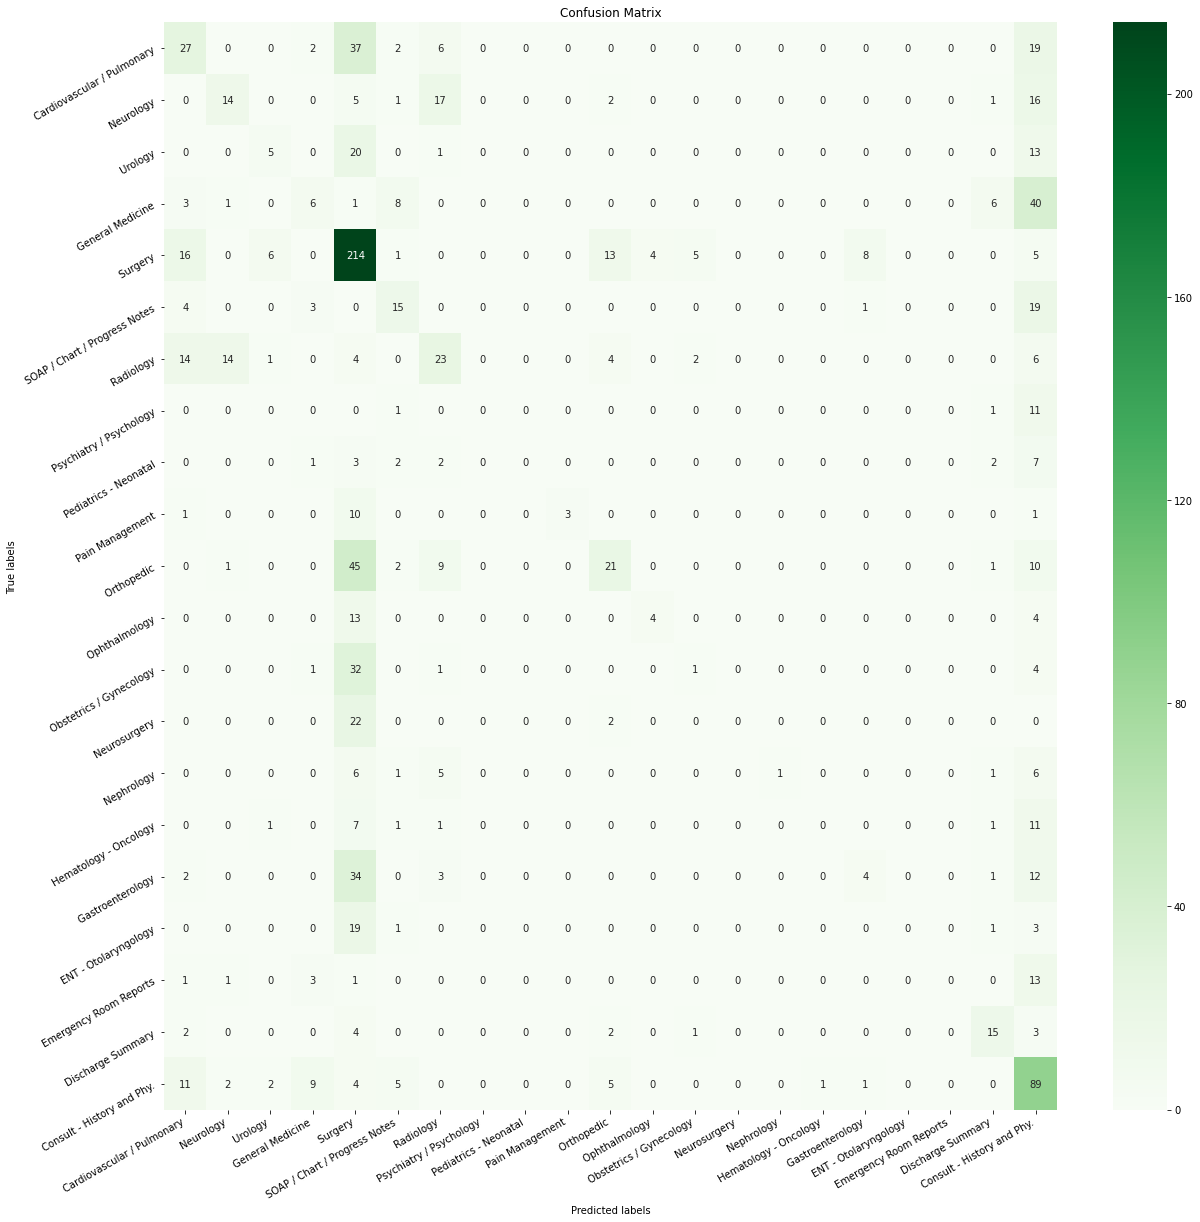

In [113]:
fig = plt.figure(figsize=(20,20))
ax= fig.add_subplot(1,1,1)
sns.heatmap(cm, annot=True, cmap="Greens",ax = ax,fmt='g'); #annot=True to annotate cells

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(labels); ax.yaxis.set_ticklabels(labels);
plt.setp(ax.get_yticklabels(), rotation=30, horizontalalignment='right')
plt.setp(ax.get_xticklabels(), rotation=30, horizontalalignment='right')     
plt.show()

In [114]:
print(classification_report(y_test,y_test_pred,labels=category_list))

                                precision    recall  f1-score   support

    Cardiovascular / Pulmonary       0.33      0.29      0.31        93
                     Neurology       0.42      0.25      0.31        56
                       Urology       0.33      0.13      0.19        39
              General Medicine       0.24      0.09      0.13        65
                       Surgery       0.44      0.79      0.57       272
 SOAP / Chart / Progress Notes       0.38      0.36      0.37        42
                     Radiology       0.34      0.34      0.34        68
       Psychiatry / Psychology       0.00      0.00      0.00        13
         Pediatrics - Neonatal       0.00      0.00      0.00        17
               Pain Management       1.00      0.20      0.33        15
                    Orthopedic       0.43      0.24      0.30        89
                 Ophthalmology       0.50      0.19      0.28        21
       Obstetrics / Gynecology       0.11      0.03      0.04  

C:\Users\prabh\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


The accuracy we got is 38% which is quite poor.
Let us apply some domain knowledge and see if we can improve the results The surgey category is kind of 
superset as there can be surgeries belonging to specializations like cardiology,neurolrogy etc. 
Similarly other categories like Emergency Room Reports, Discharge Summary, Notes also overlap with specialities. 
Hence i remove them.

In [115]:
#Verifying the model prediction

mask = med_data['medical_specialty'] ==  ' Hematology - Oncology'
oncoData = med_data[mask]
print(oncoData ['transcription'].tolist()[1])

CHIEF COMPLAINT:,  Essential thrombocytosis.,HISTORY OF PRESENT ILLNESS: , This is an extremely pleasant 64-year-old gentleman who I am following for essential thrombocytosis.  He was first diagnosed when he first saw a hematologist on 07/09/07.  At that time, his platelet count was 1,240,000.  He was initially started on Hydrea 1000 mg q.d.  On 07/11/07, he underwent a bone marrow biopsy, which showed essential thrombocytosis.  He was positive for the JAK-2 mutation.  On 11/06/07, his platelets were noted to be 766,000.  His current Hydrea dose is now 1500 mg on Mondays and Fridays and 1000 mg on all other days.  He moved to ABCD in December 2009 in an attempt to improve his wife's rheumatoid arthritis.,Overall, he is doing well.  He has a good energy level, and his ECOG performance status is 0.  He denies any fevers, chills, or night sweats.  No lymphadenopathy.  No nausea or vomiting.  No change in bowel or bladder habits.,CURRENT MEDICATIONS: , Hydrea 1500 mg on Mondays and Fridays

In [116]:
mask = med_data['medical_specialty'] ==  '  Lab Medicine - Pathology '
allergyData = med_data[mask]
print(allergyData ['transcription'].tolist())

[]


My learnings from this dataset are: This dataset is very noisy.

Lot of text in transcriptions overlaps across categories

We can apply domain knowledge to reduce the categories

It is imbalanced dataset and using SMOTE or Oversampling may improve the results

Hand coded features may improve results on this dataset but may not apply to generic transcription datasets.